In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import kagglehub
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix,
    recall_score, precision_score, f1_score
)


In [ ]:
path = kagglehub.dataset_download("cdeotte/jpeg-isic2019-512x512")

print("Path to dataset files:", path)

# List the dataset directory
print("Dataset files:", os.listdir(path))

# Define the path (modify if needed)
csv_path = os.path.join(path, "train.csv")

# Load CSV
df = pd.read_csv(csv_path)

# Display the first few rows
print(df.head())

image_folder = os.path.join(path, "train")

# List first 10 images
print(os.listdir(image_folder)[:10])

Path to dataset files: /kaggle/input/jpeg-isic2019-512x512
Dataset files: ['train.csv', 'train']
     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_0000000          -1  female        55.0                anterior torso   
1  ISIC_0000001          -1  female        30.0                anterior torso   
2  ISIC_0000002          -1  female        60.0               upper extremity   
3  ISIC_0000003          -1    male        30.0               upper extremity   
4  ISIC_0000004          -1    male        80.0               posterior torso   

  diagnosis benign_malignant  target  tfrecord  width  height  
0        NV           benign       0         4   1022     767  
1        NV           benign       0        18   1022     767  
2       MEL        malignant       1         0   1022     767  
3        NV           benign       0        24   1022     767  
4       MEL        malignant       1        14   1022     767  
['ISIC_0057312.jpg', 'ISIC_00142

In [ ]:
# Load the pre-trained model
model_path = 'final_nas_model.h5'
model = load_model(model_path)

# Define image dimensions
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for validation (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Initialize Stratified K-Fold Cross-Validation
n_splits = 5  # Use 5 folds

# StratifiedKFold ensures **each fold has the same class distribution** as the full dataset.
# This is critical for imbalanced binary classification (e.g., benign vs malignant),
# so we don't end up with folds that are all one class.
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store results
fold_histories = []
fold_metrics = {
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': []
}

# Get image paths and labels
image_paths = [os.path.join(image_folder, f"{img_name}.jpg") for img_name in df['image_name']]
labels = df['target'].values

# Convert labels to strings
labels = labels.astype(str)

# Count how many examples are in each class
class_counts = df['target'].value_counts()
total_samples = len(df)

# Compute weights inversely proportional to class frequency
# So that the model pays more attention to the minority class
class_weights = {
    0: total_samples / (2 * class_counts[0]),  # benign
    1: total_samples / (2 * class_counts[1])   # malignant
}

# These class weights are passed into .fit() to reduce bias toward the majority class during training.

Q: Why use StratifiedKFold over KFold?

➤ StratifiedKFold preserves the class balance in each fold, which is essential for fair evaluation in imbalanced datasets.

Q: Why shuffle?

➤ Shuffling ensures that the original order of data (which might be grouped or sorted) doesn't bias how folds are constructed.

Q: Why set a random_state?

➤ For reproducibility — ensures that the same folds are created every time the notebook is run.

In [ ]:
# K-fold cross validation
for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels)):
    print(f"\nTraining fold {fold + 1}/{n_splits}")

    # Loop through each of the n_splits folds (here, 5). Each iteration trains on one set of training indices and evaluates on the corresponding validation set.

    # Split data for this fold
    train_paths = np.array(image_paths)[train_idx]
    train_labels = labels[train_idx]
    val_paths = np.array(image_paths)[val_idx]
    val_labels = labels[val_idx]

    # StratifiedKFold returns indices. This converts them into actual image paths and labels for the fold.

    # Create data generators for this fold
    train_generator = train_datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths, 'class': train_labels}),
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    val_generator = val_datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths, 'class': val_labels}),
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    # Keras generators load and preprocess images for training and validation. Binary mode is used since this is a two-class problem.

    # Clone the base model to avoid weight leakage between folds
    fold_model = tf.keras.models.clone_model(model)
    fold_model.set_weights(model.get_weights())

    # Compile the model with additional metrics
    fold_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    #  In addition to accuracy, recall and precision are logged for clinical relevance, and AUC shows overall discrimination power.

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_recall',  # Stop early if recall doesn't improve
            patience=5,
            restore_best_weights=True,
            mode='max'
        ),
        tf.keras.callbacks.ModelCheckpoint(
            f'fold_{fold+1}_best_model.h5',
            monitor='val_recall',  # Save best model of this fold
            save_best_only=True,
            mode='max'
        )
    ]

    # Train the model with class weights
    history = fold_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=callbacks,
        class_weight=class_weights
    )

    # Training includes class weights to handle class imbalance and uses callbacks to stop early and save the best-performing model.

    # Store results
    fold_histories.append(history)

    # Each fold's training history is stored so we can later plot metrics across all folds.

    # Get predictions for the validation set
    val_generator.reset()
    predictions = fold_model.predict(val_generator)
    predictions = (predictions > 0.5).astype(int)

    # Evaluates how well the model performs on unseen validation data for this fold.

    # Calculate metrics
    val_labels_numeric = val_generator.labels
    fold_metrics['accuracy'].append(np.mean(predictions == val_labels_numeric))
    fold_metrics['recall'].append(recall_score(val_labels_numeric, predictions))
    fold_metrics['precision'].append(precision_score(val_labels_numeric, predictions))
    fold_metrics['f1'].append(f1_score(val_labels_numeric, predictions))

    # Print fold results
    print(f"\nFold {fold + 1} Results:")
    print(f"Accuracy: {fold_metrics['accuracy'][-1]:.4f}")
    print(f"Recall: {fold_metrics['recall'][-1]:.4f}")
    print(f"Precision: {fold_metrics['precision'][-1]:.4f}")
    print(f"F1 Score: {fold_metrics['f1'][-1]:.4f}")

    # Print confusion matrix
    cm = confusion_matrix(val_labels_numeric, predictions)
    print("\nConfusion Matrix:")
    print(cm)


Training fold 1/5
Found 20264 validated image filenames belonging to 2 classes.
Found 5067 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.6902 - auc: 0.7578 - loss: 0.5841 - precision: 0.3249 - recall: 0.6764

634/634 ━━━━━━━━━━━━━━━━━━━━ 456s 659ms/step - accuracy: 0.6902 - auc: 0.7578 - loss: 0.5841 - precision: 0.3249 - recall: 0.6764 - val_accuracy: 0.7886 - val_auc: 0.8070 - val_loss: 0.4794 - val_precision: 0.4358 - val_recall: 0.6221
Epoch 2/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7111 - auc: 0.7869 - loss: 0.5483 - precision: 0.3427 - recall: 0.6889

634/634 ━━━━━━━━━━━━━━━━━━━━ 263s 415ms/step - accuracy: 0.7111 - auc: 0.7869 - loss: 0.5483 - precision: 0.3427 - recall: 0.6889 - val_accuracy: 0.7008 - val_auc: 0.8089 - val_loss: 0.5766 - val_precision: 0.3444 - val_recall: 0.7470
Epoch 3/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 260s 410ms/step - accuracy: 0.7095 - auc: 0.7901 - loss: 0.5474 - precision: 0.3436 - recall: 0.6969 - val_accuracy: 0.8048 - val_auc: 0.8087 - val_loss: 0.4559 - val_precision: 0.4623 - val_recall: 0.5691
Epoch 4/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 258s 407ms/step - accuracy: 0.7181 - auc: 0.8003 - loss: 0.5383 - precision: 0.3606 - recall: 0.7189 - val_accuracy: 0.7630 - val_auc: 0.8157 - val_loss: 0.5103 - val_precision: 0.4033 - val_recall: 0.6818
Epoch 5/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 258s 407ms/step - accuracy: 0.7332 - auc: 0.8041 - loss: 0.5316 - precision: 0.3703 - recall: 0.7243 - val_accuracy: 0.8186 - val_auc: 0.8147 - val_loss: 0.4168 - val_precision: 0.4931 - val_recall: 0.5536
Epoch 6/50
634/634 ━━━━━━━━

634/634 ━━━━━━━━━━━━━━━━━━━━ 263s 415ms/step - accuracy: 0.7413 - auc: 0.8068 - loss: 0.5238 - precision: 0.3726 - recall: 0.6996 - val_accuracy: 0.6716 - val_auc: 0.8153 - val_loss: 0.5877 - val_precision: 0.3274 - val_recall: 0.7956
Epoch 7/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 261s 412ms/step - accuracy: 0.7251 - auc: 0.8104 - loss: 0.5172 - precision: 0.3585 - recall: 0.7056 - val_accuracy: 0.7859 - val_auc: 0.8171 - val_loss: 0.4662 - val_precision: 0.4340 - val_recall: 0.6541
Epoch 8/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 259s 409ms/step - accuracy: 0.7436 - auc: 0.8183 - loss: 0.5125 - precision: 0.3805 - recall: 0.7134 - val_accuracy: 0.8072 - val_auc: 0.8173 - val_loss: 0.4394 - val_precision: 0.4678 - val_recall: 0.5779
Epoch 9/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 260s 409ms/step - accuracy: 0.7384 - auc: 0.8165 - loss: 0.5211 - precision: 0.3846 - recall: 0.7323 - val_accuracy: 0.7703 - val_auc: 0.8164 - val_loss: 0.4627 - val_precision: 0.4093 - val_recall: 0.6453
Epoch 10/50
634/634 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.6887 - auc: 0.7464 - loss: 0.5927 - precision: 0.3189 - recall: 0.6684

634/634 ━━━━━━━━━━━━━━━━━━━━ 326s 465ms/step - accuracy: 0.6887 - auc: 0.7465 - loss: 0.5927 - precision: 0.3189 - recall: 0.6685 - val_accuracy: 0.7989 - val_auc: 0.7953 - val_loss: 0.4701 - val_precision: 0.4506 - val_recall: 0.5808
Epoch 2/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7038 - auc: 0.7802 - loss: 0.5587 - precision: 0.3398 - recall: 0.6919

634/634 ━━━━━━━━━━━━━━━━━━━━ 262s 413ms/step - accuracy: 0.7038 - auc: 0.7802 - loss: 0.5587 - precision: 0.3398 - recall: 0.6919 - val_accuracy: 0.8022 - val_auc: 0.8037 - val_loss: 0.4603 - val_precision: 0.4580 - val_recall: 0.5907
Epoch 3/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.7206 - auc: 0.7863 - loss: 0.5452 - precision: 0.3451 - recall: 0.6734

634/634 ━━━━━━━━━━━━━━━━━━━━ 261s 411ms/step - accuracy: 0.7206 - auc: 0.7864 - loss: 0.5452 - precision: 0.3451 - recall: 0.6734 - val_accuracy: 0.7302 - val_auc: 0.8027 - val_loss: 0.5283 - val_precision: 0.3688 - val_recall: 0.7201
Epoch 4/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 261s 411ms/step - accuracy: 0.7253 - auc: 0.8065 - loss: 0.5314 - precision: 0.3640 - recall: 0.7276 - val_accuracy: 0.7424 - val_auc: 0.8034 - val_loss: 0.5140 - val_precision: 0.3791 - val_recall: 0.6958
Epoch 5/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 257s 406ms/step - accuracy: 0.7266 - auc: 0.8088 - loss: 0.5266 - precision: 0.3653 - recall: 0.7235 - val_accuracy: 0.7771 - val_auc: 0.8079 - val_loss: 0.4770 - val_precision: 0.4196 - val_recall: 0.6493
Epoch 6/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 259s 409ms/step - accuracy: 0.7223 - auc: 0.8064 - loss: 0.5332 - precision: 0.3645 - recall: 0.7165 - val_accuracy: 0.7963 - val_auc: 0.8116 - val_loss: 0.4629 - val_precision: 0.4486 - val_recall: 0.6184
Epoch 7/50
634/634 ━━━━━━━━

634/634 ━━━━━━━━━━━━━━━━━━━━ 262s 413ms/step - accuracy: 0.7422 - auc: 0.8115 - loss: 0.5147 - precision: 0.3685 - recall: 0.7003 - val_accuracy: 0.7173 - val_auc: 0.8031 - val_loss: 0.5419 - val_precision: 0.3564 - val_recall: 0.7246
Epoch 8/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7313 - auc: 0.8157 - loss: 0.5202 - precision: 0.3747 - recall: 0.7299

634/634 ━━━━━━━━━━━━━━━━━━━━ 260s 410ms/step - accuracy: 0.7314 - auc: 0.8157 - loss: 0.5202 - precision: 0.3747 - recall: 0.7299 - val_accuracy: 0.7252 - val_auc: 0.8198 - val_loss: 0.5508 - val_precision: 0.3692 - val_recall: 0.7622
Epoch 9/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 261s 412ms/step - accuracy: 0.7412 - auc: 0.8101 - loss: 0.5216 - precision: 0.3734 - recall: 0.7117 - val_accuracy: 0.7681 - val_auc: 0.8121 - val_loss: 0.4810 - val_precision: 0.4090 - val_recall: 0.6737
Epoch 10/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 258s 407ms/step - accuracy: 0.7322 - auc: 0.8179 - loss: 0.5128 - precision: 0.3697 - recall: 0.7187 - val_accuracy: 0.7538 - val_auc: 0.8074 - val_loss: 0.5023 - val_precision: 0.3912 - val_recall: 0.6825
Epoch 11/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 258s 407ms/step - accuracy: 0.7355 - auc: 0.8169 - loss: 0.5164 - precision: 0.3748 - recall: 0.7219 - val_accuracy: 0.7396 - val_auc: 0.8121 - val_loss: 0.5155 - val_precision: 0.3774 - val_recall: 0.7069
Epoch 12/50
634/634 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6856 - auc: 0.7595 - loss: 0.5817 - precision: 0.3197 - recall: 0.6663

634/634 ━━━━━━━━━━━━━━━━━━━━ 319s 454ms/step - accuracy: 0.6856 - auc: 0.7595 - loss: 0.5817 - precision: 0.3197 - recall: 0.6663 - val_accuracy: 0.8255 - val_auc: 0.7809 - val_loss: 0.4139 - val_precision: 0.5135 - val_recall: 0.4215
Epoch 2/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7207 - auc: 0.7911 - loss: 0.5471 - precision: 0.3551 - recall: 0.6904

634/634 ━━━━━━━━━━━━━━━━━━━━ 265s 418ms/step - accuracy: 0.7207 - auc: 0.7911 - loss: 0.5471 - precision: 0.3551 - recall: 0.6903 - val_accuracy: 0.7197 - val_auc: 0.7907 - val_loss: 0.5549 - val_precision: 0.3557 - val_recall: 0.7035
Epoch 3/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 258s 406ms/step - accuracy: 0.7115 - auc: 0.7881 - loss: 0.5510 - precision: 0.3495 - recall: 0.6996 - val_accuracy: 0.7965 - val_auc: 0.7929 - val_loss: 0.4711 - val_precision: 0.4463 - val_recall: 0.5841
Epoch 4/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 261s 411ms/step - accuracy: 0.7249 - auc: 0.7957 - loss: 0.5405 - precision: 0.3616 - recall: 0.6985 - val_accuracy: 0.7519 - val_auc: 0.7957 - val_loss: 0.4973 - val_precision: 0.3855 - val_recall: 0.6571
Epoch 5/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 258s 407ms/step - accuracy: 0.7248 - auc: 0.8022 - loss: 0.5349 - precision: 0.3643 - recall: 0.7081 - val_accuracy: 0.7868 - val_auc: 0.8037 - val_loss: 0.4643 - val_precision: 0.4330 - val_recall: 0.6294
Epoch 6/50
634/634 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6959 - auc: 0.7576 - loss: 0.5797 - precision: 0.3250 - recall: 0.6678

634/634 ━━━━━━━━━━━━━━━━━━━━ 321s 457ms/step - accuracy: 0.6959 - auc: 0.7576 - loss: 0.5797 - precision: 0.3250 - recall: 0.6678 - val_accuracy: 0.7546 - val_auc: 0.7969 - val_loss: 0.4989 - val_precision: 0.3877 - val_recall: 0.6471
Epoch 2/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7289 - auc: 0.7957 - loss: 0.5353 - precision: 0.3557 - recall: 0.6940

634/634 ━━━━━━━━━━━━━━━━━━━━ 259s 409ms/step - accuracy: 0.7289 - auc: 0.7957 - loss: 0.5353 - precision: 0.3557 - recall: 0.6940 - val_accuracy: 0.7651 - val_auc: 0.8167 - val_loss: 0.5028 - val_precision: 0.4068 - val_recall: 0.6903
Epoch 3/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 258s 407ms/step - accuracy: 0.7120 - auc: 0.7850 - loss: 0.5517 - precision: 0.3477 - recall: 0.6991 - val_accuracy: 0.8225 - val_auc: 0.8166 - val_loss: 0.4345 - val_precision: 0.5027 - val_recall: 0.5166
Epoch 4/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 261s 412ms/step - accuracy: 0.7262 - auc: 0.7963 - loss: 0.5393 - precision: 0.3609 - recall: 0.6873 - val_accuracy: 0.7692 - val_auc: 0.8175 - val_loss: 0.4840 - val_precision: 0.4098 - val_recall: 0.6659
Epoch 5/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 260s 409ms/step - accuracy: 0.7275 - auc: 0.8088 - loss: 0.5277 - precision: 0.3672 - recall: 0.7100 - val_accuracy: 0.7900 - val_auc: 0.8213 - val_loss: 0.4600 - val_precision: 0.4378 - val_recall: 0.6228
Epoch 6/50
634/634 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.6878 - auc: 0.7598 - loss: 0.5869 - precision: 0.3271 - recall: 0.6796

634/634 ━━━━━━━━━━━━━━━━━━━━ 321s 457ms/step - accuracy: 0.6878 - auc: 0.7598 - loss: 0.5869 - precision: 0.3271 - recall: 0.6796 - val_accuracy: 0.7438 - val_auc: 0.7921 - val_loss: 0.5156 - val_precision: 0.3759 - val_recall: 0.6575
Epoch 2/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 260s 409ms/step - accuracy: 0.7120 - auc: 0.7907 - loss: 0.5475 - precision: 0.3503 - recall: 0.7078 - val_accuracy: 0.7450 - val_auc: 0.7894 - val_loss: 0.5148 - val_precision: 0.3765 - val_recall: 0.6519
Epoch 3/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 259s 408ms/step - accuracy: 0.7109 - auc: 0.7860 - loss: 0.5478 - precision: 0.3463 - recall: 0.7120 - val_accuracy: 0.7692 - val_auc: 0.7954 - val_loss: 0.4824 - val_precision: 0.4043 - val_recall: 0.6166
Epoch 4/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 257s 406ms/step - accuracy: 0.7182 - auc: 0.7958 - loss: 0.5413 - precision: 0.3550 - recall: 0.7036 - val_accuracy: 0.7813 - val_auc: 0.7953 - val_loss: 0.4770 - val_precision: 0.4210 - val_recall: 0.5978
Epoch 5/50
634/634 ━━━━━━━━

634/634 ━━━━━━━━━━━━━━━━━━━━ 260s 410ms/step - accuracy: 0.7321 - auc: 0.8078 - loss: 0.5213 - precision: 0.3635 - recall: 0.7045 - val_accuracy: 0.7197 - val_auc: 0.8022 - val_loss: 0.5323 - val_precision: 0.3587 - val_recall: 0.7227
Epoch 7/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 260s 410ms/step - accuracy: 0.7338 - auc: 0.8185 - loss: 0.5211 - precision: 0.3804 - recall: 0.7392 - val_accuracy: 0.7945 - val_auc: 0.7935 - val_loss: 0.4520 - val_precision: 0.4410 - val_recall: 0.5613
Epoch 8/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 260s 410ms/step - accuracy: 0.7373 - auc: 0.8165 - loss: 0.5130 - precision: 0.3739 - recall: 0.7248 - val_accuracy: 0.7937 - val_auc: 0.8031 - val_loss: 0.4438 - val_precision: 0.4408 - val_recall: 0.5757
Epoch 9/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 263s 414ms/step - accuracy: 0.7381 - auc: 0.8195 - loss: 0.5120 - precision: 0.3783 - recall: 0.7186 - val_accuracy: 0.8024 - val_auc: 0.8025 - val_loss: 0.4471 - val_precision: 0.4573 - val_recall: 0.5680
Epoch 10/50
634/634 ━━━━━━━

Q: Why clone the model?

➤ Cloning resets the model to its original state, ensuring each fold starts training from the same weights — crucial for valid comparisons across folds.

Q: Why monitor recall instead of loss or accuracy?

➤ In medical tasks, recall is vital — we want to catch as many malignant cases as possible, even if it lowers precision.

In [ ]:
from google.colab import files
for fold in range(n_splits):
    model_path = f'fold_{fold+1}_best_model.h5'
    files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Cross-validation Results:
Average Accuracy: 0.5877 ± 0.0270
Average Recall: 0.3609 ± 0.0436
Average Precision: 0.1771 ± 0.0066
Average F1: 0.2370 ± 0.0132


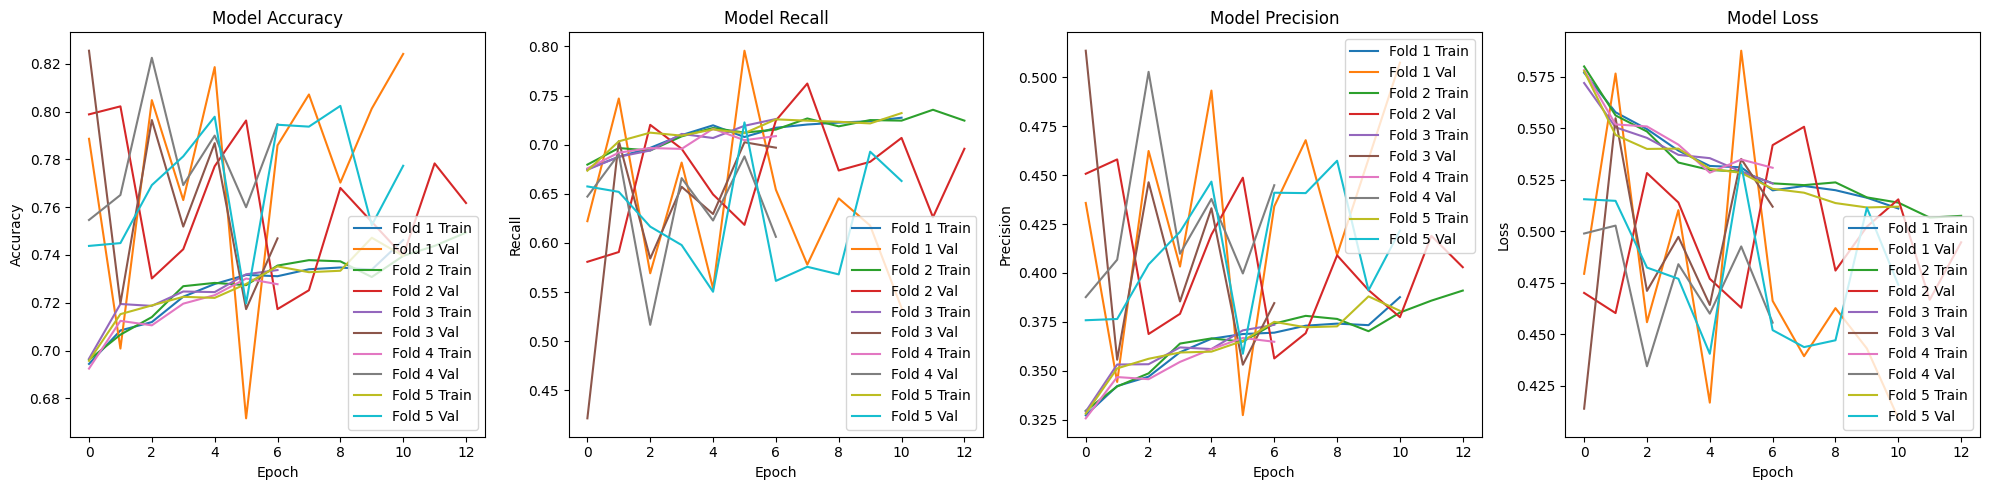

In [ ]:
# Print overall results
print("\nCross-validation Results:")
for metric in fold_metrics:
    mean_score = np.mean(fold_metrics[metric])
    std_score = np.std(fold_metrics[metric])
    print(f"Average {metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

# Plot training history for each fold
plt.figure(figsize=(20, 5))
metrics_to_plot = ['accuracy', 'recall', 'precision', 'loss']
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, 4, i+1)
    for j, history in enumerate(fold_histories):
        plt.plot(history.history[metric], label=f'Fold {j+1} Train')
        plt.plot(history.history[f'val_{metric}'], label=f'Fold {j+1} Val')
    plt.title(f'Model {metric.capitalize()}')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend()

plt.tight_layout()
plt.show()